<a href="https://colab.research.google.com/github/julika333/TMS-DS/blob/main/lesson_21_k_mean_dbscan/HW_21_claster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [245]:
from pathlib import Path
import urllib.request
colab_path = Path("datasets/Mall_Customers.csv")
Path("datasets").mkdir(parents=True, exist_ok=True)
url = "https://raw.githubusercontent.com/julika333/TMS-DS/main/lesson_21_k_mean_dbscan/Mall_Customers.csv"
urllib.request.urlretrieve(url, colab_path)

(PosixPath('datasets/Mall_Customers.csv'),
 <http.client.HTTPMessage at 0x7b8f3d1cd5d0>)

#Загружаем данные

In [246]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt

data = pd.read_csv(Path("/content/datasets/Mall_Customers.csv"))
print(data.head())
print("\n***Data Info***\n")
data.info()

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

***Data Info***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#Мини подготовка данных
1. Удалим колонку CustomerID (кажется в ней нет смысла для анализа)
1. Столбец Gender перекодируем в 0/1

In [247]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

if "CustomerID" in data.columns:
  data.drop("CustomerID", axis=1, inplace=True)

data["GenderCd"] = gender_encoded
if "Gender" in data.columns:
  gender = data[["Gender"]]
  gender_encoded_ord = OrdinalEncoder()
  gender_encoded = gender_encoded_ord.fit_transform(gender)
  data.drop("Gender", axis=1, inplace=True)
print("\n***data***\n")
print(data.head())

# стандартизируем
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
print("\n***data scaled***\n")
print(pd.DataFrame(data_scaled, columns=data.columns).head())

metrics_df = pd.DataFrame(columns=['Model', 'SilhouetteScore', 'DaviesBouldinIndex'])


***data***

   Age  Annual Income (k$)  Spending Score (1-100)  GenderCd
0   19                  15                      39       1.0
1   21                  15                      81       1.0
2   20                  16                       6       0.0
3   23                  16                      77       0.0
4   31                  17                      40       0.0

***data scaled***

        Age  Annual Income (k$)  Spending Score (1-100)  GenderCd
0 -1.424569           -1.738999               -0.434801  1.128152
1 -1.281035           -1.738999                1.195704  1.128152
2 -1.352802           -1.700830               -1.715913 -0.886405
3 -1.137502           -1.700830                1.040418 -0.886405
4 -0.563369           -1.662660               -0.395980 -0.886405


#K-Mean кластеризация

##Выбираем количество кластеров (вариант со всеми фичами)

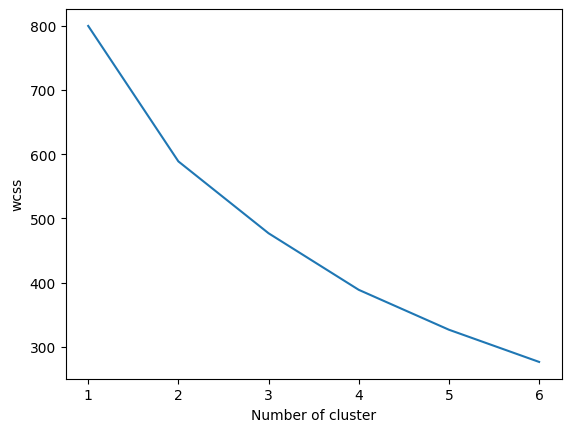

In [248]:
data_kmean = data_scaled.copy()

wcss = {}
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=33, n_init=10).fit(data_kmean)
    wcss[k] = kmeans.inertia_  #сумма квадратов расстояний

plt.figure()
plt.plot(list(wcss.keys()), list(wcss.values()))
plt.xlabel("Number of cluster")
plt.ylabel("wcss")
plt.show()


Явно видно 2 клстера, скорее всего из-за Male/Female.

   Age  Annual Income (k$)  Spending Score (1-100)  GenderCd  Cluster_kmean
0   19                  15                      39       1.0              1
1   21                  15                      81       1.0              1
2   20                  16                       6       0.0              0
3   23                  16                      77       0.0              1
4   31                  17                      40       0.0              1


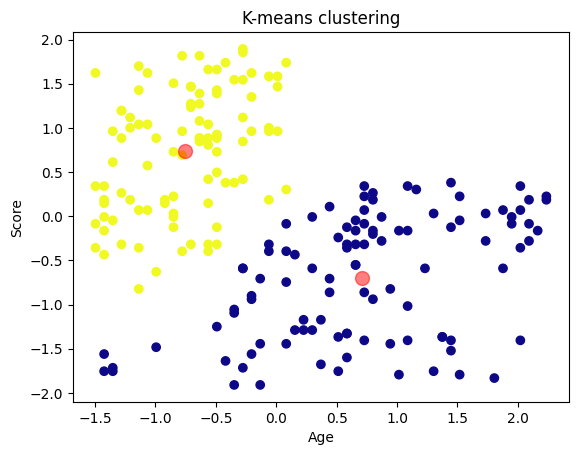

In [249]:
# from sklearn.decomposition import PCA
# Модель для двух кластеров
kmeans = KMeans(n_clusters=2, random_state=33,  n_init=10)
kmeans.fit(data_kmean)
cluster_labels = kmeans.labels_

# Добавим найденные метки кластера в исходный датасет, для истории :)
data['Cluster_kmean'] = cluster_labels
print(data.head())
plt.scatter(data_kmean[:, 0], data_kmean[:, 2], c=cluster_labels, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=100, alpha=0.5)  # Центры кластеров
plt.title("K-means clustering")
plt.xlabel("Age")
plt.ylabel("Score")
plt.show()

new_m = pd.DataFrame({'Model': ['KMeans'], 'SilhouetteScore': [silhouette_score(data_kmean, cluster_labels)], 'DaviesBouldinIndex': [davies_bouldin_score(data_kmean, cluster_labels)]})
metrics_df = pd.concat([metrics_df, new_m], ignore_index=True)


**Max, вопрос:**
я вот когда строила график(выше) просто перебором подобрала параметры, чтобы красиво отобразить кдластеры (взяла Age(0) и Score(2)). `data_kmean[:, 0], data_kmean[:, 2]`
Может быть есть какой-то научный подход? или может быть так подбирать вообще нельзя?

##Выбираем количество кластеров (вариант без Gender, вдруг есть что-то ещё...)

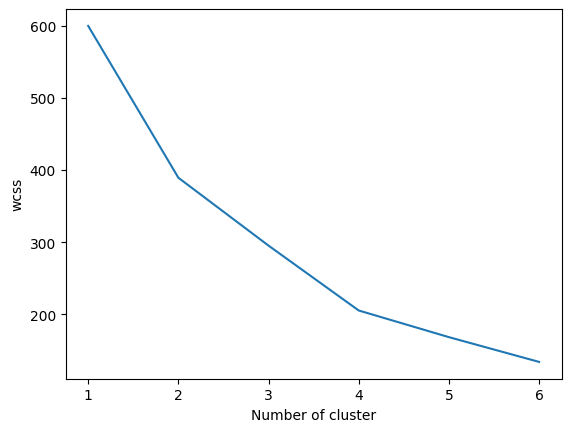

In [250]:
data_kmean_ng = data_scaled.copy()

data_kmean_ng = np.delete(data_kmean_ng, 3, axis=1) #удалили Gender

wcss = {}
for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=33, n_init=10).fit(data_kmean_ng)
    wcss[k] = kmeans.inertia_  #сумма квадратов расстояний

plt.figure()
plt.plot(list(wcss.keys()), list(wcss.values()))
plt.xlabel("Number of cluster")
plt.ylabel("wcss")
plt.show()


### сейчас уже видим второй перелом на 4 кластера

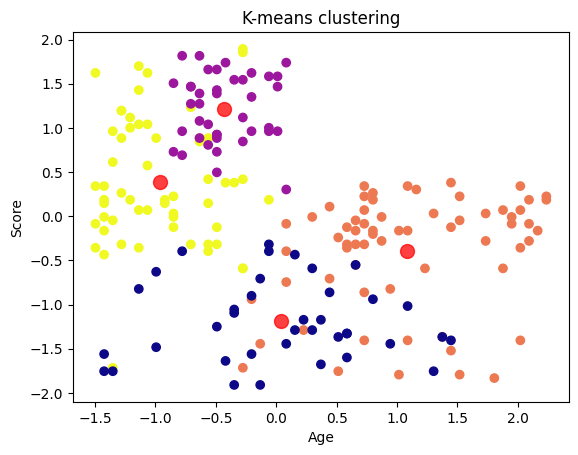

In [251]:
# Выберем 4 кластера
kmeans = KMeans(n_clusters=4, random_state=33,  n_init=10)
kmeans.fit(data_kmean_ng)
cluster_labels = kmeans.labels_

# Добавим найденные метки кластера в исходный датасет, для истории :)
data['Cluster_kmean_noGender'] = cluster_labels
plt.scatter(data_kmean_ng[:, 0], data_kmean_ng[:, 2], c=cluster_labels, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='red', s=100, alpha=0.75)  # Центры кластеров
plt.title("K-means clustering")
plt.xlabel("Age")
plt.ylabel("Score")
plt.show()

new_m = pd.DataFrame({'Model': ['KMeans_noGender'], 'SilhouetteScore': [silhouette_score(data_kmean_ng, cluster_labels)], 'DaviesBouldinIndex': [davies_bouldin_score(data_kmean_ng, cluster_labels)]})
metrics_df = pd.concat([metrics_df, new_m], ignore_index=True)


Не сказала бы, что здесь есть реально 4 кластера ...

In [252]:
data

,Age,Annual Income (k$),Spending Score (1-100),GenderCd,Cluster_kmean,Cluster_kmean_noGender
0,19,15,39,1.0,1,3
1,21,15,81,1.0,1,3
2,20,16,6,0.0,0,3
3,23,16,77,0.0,1,3
4,31,17,40,0.0,1,3
...,...,...,...,...,...,...
195,35,120,79,0.0,1,1
196,45,126,28,0.0,0,0
197,32,126,74,1.0,1,1
198,32,137,18,1.0,0,0


Судя по полученным данным, Cluster_kmean всё же разбил на кластеры не только по Gender

#DBSCAN кластеризация

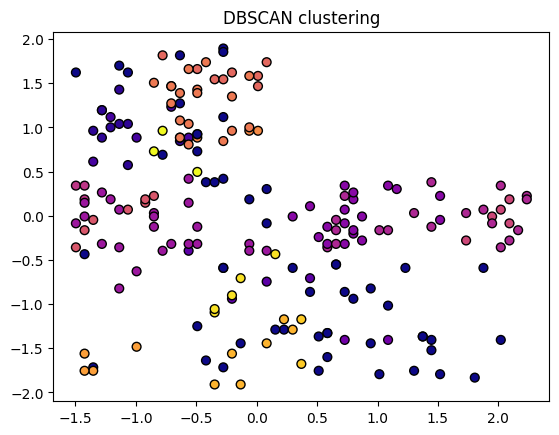

In [253]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

data_dbscan = data_scaled.copy()

dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(data_dbscan)
# Добавим найденные метки
data['Cluster_dbscan'] = dbscan_labels

plt.scatter(data_dbscan[:, 0], data_dbscan[:, 2], c=dbscan_labels, cmap='plasma', marker='o', edgecolor='k', s=40)
plt.title("DBSCAN clustering")
plt.show()

new_m = pd.DataFrame({'Model': ['DBSCAN'], 'SilhouetteScore': [silhouette_score(data_dbscan, dbscan_labels)], 'DaviesBouldinIndex': [davies_bouldin_score(data_dbscan, dbscan_labels)]})
metrics_df = pd.concat([metrics_df, new_m], ignore_index=True)

Перебрала много вариантов `(eps=0.6, min_samples=4)`, похоже под мой датасет DBSCAN вообще никак не поможет

#Иерархическая кластеризация

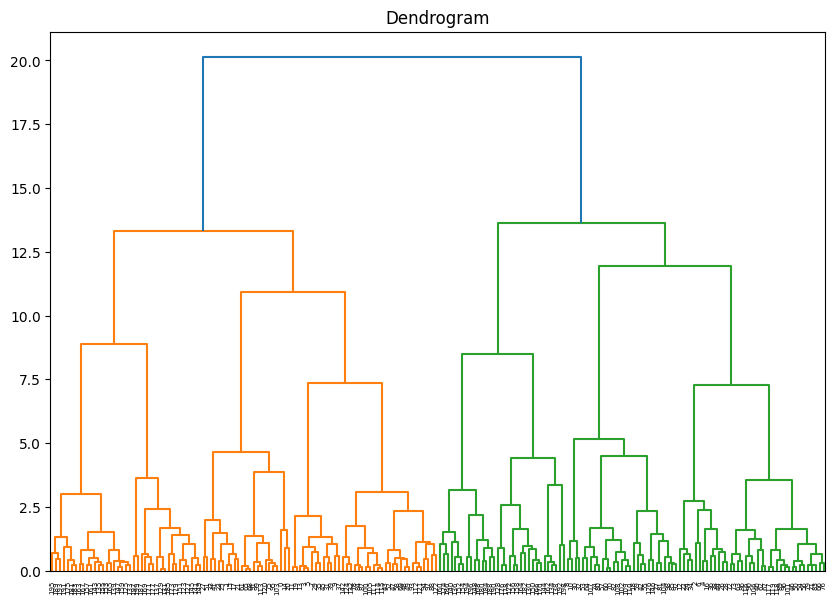

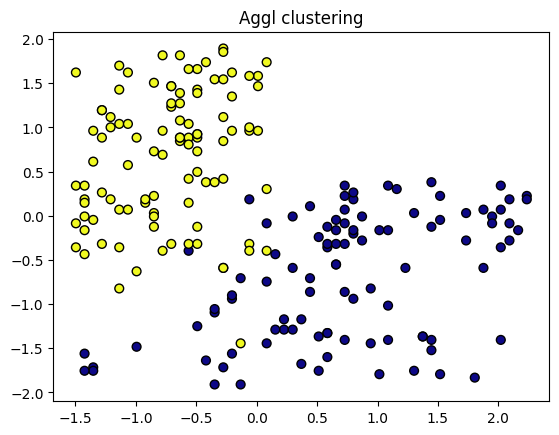

In [254]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

data_aggl = data_scaled.copy()

agg_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agg_labels = agg_clustering.fit_predict(data_aggl)
# Добавим найденные метки
data['Cluster_aggl'] = agg_labels

plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dendro = dendrogram(linkage(data_aggl, method='ward'))
plt.show()


plt.scatter(data_aggl[:, 0], data_aggl[:, 2], c=agg_labels, cmap='plasma', marker='o', edgecolor='k', s=40)
plt.title("Aggl clustering")
plt.show()

new_m = pd.DataFrame({'Model': ['AgglomerativeClustering'], 'SilhouetteScore': [silhouette_score(data_aggl, agg_labels)], 'DaviesBouldinIndex': [davies_bouldin_score(data_aggl, agg_labels)]})
metrics_df = pd.concat([metrics_df, new_m], ignore_index=True)

In [255]:
metrics_df

,Model,SilhouetteScore,DaviesBouldinIndex
0,KMeans,0.251815,1.613751
1,KMeans_noGender,0.403958,0.930796
2,DBSCAN,0.214604,1.401889
3,AgglomerativeClustering,0.241780,1.661108


In [256]:
data


,Age,Annual Income (k$),Spending Score (1-100),GenderCd,Cluster_kmean,Cluster_kmean_noGender,Cluster_dbscan,Cluster_aggl
0,19,15,39,1.0,1,3,-1,1
1,21,15,81,1.0,1,3,1,1
2,20,16,6,0.0,0,3,-1,0
3,23,16,77,0.0,1,3,0,1
4,31,17,40,0.0,1,3,2,0
...,...,...,...,...,...,...,...,...
195,35,120,79,0.0,1,1,-1,1
196,45,126,28,0.0,0,0,-1,0
197,32,126,74,1.0,1,1,-1,1
198,32,137,18,1.0,0,0,-1,0


In [257]:
cluster_avg = data.groupby('Cluster_kmean').mean()
cluster_avg

,Age,Annual Income (k$),Spending Score (1-100),GenderCd,Cluster_kmean_noGender,Cluster_dbscan,Cluster_aggl
Cluster_kmean,,,,,,,
0,48.728155,60.495146,32.184466,0.466019,1.349515,4.834951,0.048544
1,28.360825,60.628866,69.329897,0.412371,2.082474,5.670103,0.979381
